In [1]:
import os
import pandas as pd
import numpy as np

folder_path = 'Processed_final_class/'

sequences = []
labels = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        data = pd.read_csv(file_path)

        # Convert specific columns to integers directly within the DataFrame

        data['Samples'] = pd.to_numeric(data['Samples'], errors='coerce').astype(int)
        data['Class_Label'] = pd.to_numeric(data['Class_Label'], errors='coerce').astype(int)


        # Extract features

        sequence = data[['Samples']]
        sequences.append(sequence.values)

        # Extract label
        label = data['Class_Label']
        labels.append(label)

# Convert lists to numpy arrays
X = np.array(sequences)
y = np.array(labels)


In [2]:
# Check for unique files
files = os.listdir(folder_path)
print("Total files:", len(files))
print("Unique files:", len(set(files)))


Total files: 6379
Unique files: 6379


In [3]:
sample_file_path = os.path.join(folder_path, files[0])
sample_data = pd.read_csv(sample_file_path)
print(sample_data.head())  # See first few rows
print("Unique rows in sample file:", sample_data.drop_duplicates().shape[0])


   Sample_no  Samples  Class_Label       x_cor        y_cor   z_cor  \
0        101      275            0  303787.821  6558103.231  43.546   
1        102      252            0  303787.821  6558103.231  43.546   
2        103      225            0  303787.821  6558103.231  43.546   
3        104      197            0  303787.821  6558103.231  43.546   
4        105      233            0  303787.821  6558103.231  43.546   

   Sample_Length    Point  Returning_Point  Final_Class  
0        0.05996  9.63383              160            1  
1        0.05996  9.63383              160            1  
2        0.05996  9.63383              160            1  
3        0.05996  9.63383              160            1  
4        0.05996  9.63383              160            1  
Unique rows in sample file: 300


In [4]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (6379, 300, 1)
Shape of y: (6379, 300)


In [5]:
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))

Label distribution: {0: 1072781, 1: 101809, 2: 615134, 3: 53863, 4: 70113}


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, LayerNormalization
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


num_classes = 5
y_one_hot = np.array([to_categorical(y_seq, num_classes=num_classes) for y_seq in y])

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)


y_train_flat = np.argmax(y_train, axis=-1).flatten()  # Flatten y_train to get 1D array of class labels


class_weights = compute_class_weight('balanced', classes=np.unique(y_train_flat), y=y_train_flat)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)


def assign_sample_weights(y_train, class_weights_dict):
    sample_weights = np.ones((y_train.shape[0], y_train.shape[1]))  # Shape: (num_samples, num_timesteps)
    
    for i in range(y_train.shape[0]):  # Iterate over samples
        for t in range(y_train.shape[1]):  # Iterate over time steps
            class_label = np.argmax(y_train[i, t])  # Get the class label at this time step
            sample_weights[i, t] = class_weights_dict[class_label]  # Assign the weight based on the class
    
    return sample_weights


sample_weights_train = assign_sample_weights(y_train, class_weights_dict)
print("Sample Weights Shape:", sample_weights_train.shape)


input_layer = Input(shape=(300, 1))


x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = Dropout(0.5)(x)


x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.5)(x)

# TimeDistributed output layer to classify at each time step
output_layer = TimeDistributed(Dense(5, activation='softmax'))(x)


model = Model(inputs=input_layer, outputs=output_layer)


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=16,  
                    sample_weight=sample_weights_train)  




test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


Class Weights: {0: 0.35666400684951455, 1: 3.758285461776403, 2: 0.6225828097358629, 3: 7.103285077951003, 4: 5.459408376869996}
Sample Weights Shape: (5103, 300)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 1)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 256)         133120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 128)         164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (

In [7]:
train_loss = history.history['loss']  # Training loss per epoch
train_accuracy = history.history['accuracy']  # Training accuracy per epoch


val_loss = history.history['val_loss']  # Validation loss per epoch
val_accuracy = history.history['val_accuracy']  # Validation accuracy per epoch

# Print final epoch accuracy and loss
print(f"Final training accuracy: {train_accuracy[-1] * 100:.2f}%")
print(f"Final training loss: {train_loss[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracy[-1] * 100:.2f}%")
print(f"Final validation loss: {val_loss[-1]:.4f}")


Final training accuracy: 93.41%
Final training loss: 0.1806
Final validation accuracy: 94.37%
Final validation loss: 0.1609


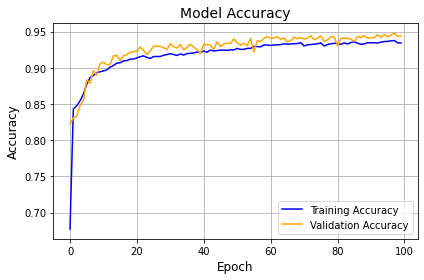

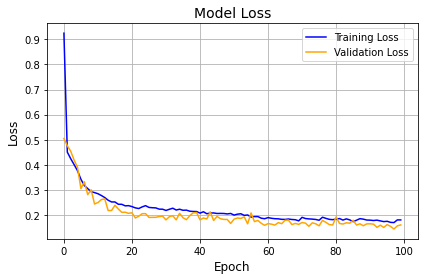

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities (one-hot) to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)

# Convert true labels from one-hot encoding to class labels
y_test_labels = np.argmax(y_test, axis=-1)

# Flatten the arrays if necessary to ensure they're 1D
y_pred_labels = y_pred_labels.flatten()
y_test_labels = y_test_labels.flatten()

# Generate a classification report
report = classification_report(y_test_labels, y_pred_labels, digits=4)

# Print the classification report
print(report)



40/40 [==============================] - 16s 339ms/step
              precision    recall  f1-score   support

           0     0.9992    0.9510    0.9745    214326
           1     0.7088    0.9607    0.8157     20341
           2     0.9893    0.9257    0.9565    123344
           3     0.6609    0.9309    0.7730     10759
           4     0.6614    0.9747    0.7880     14030

    accuracy                         0.9437    382800
   macro avg     0.8039    0.9486    0.8616    382800
weighted avg     0.9587    0.9437    0.9478    382800



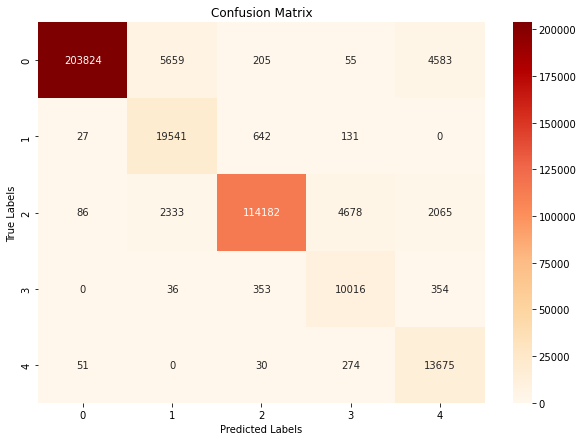

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(y_test_labels, y_pred_labels)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
model.save('seq_BI_lstm_model.h5')

In [12]:
import numpy as np


correct_predictions = np.sum(y_pred_labels == y_test_labels)
total_points = len(y_test_labels)

point_accuracy = correct_predictions / total_points

print(f"Point-by-point accuracy: {point_accuracy * 100:.2f}%")


Point-by-point accuracy: 94.37%


# Confidence Score of any text file

In [13]:
import numpy as np

# checking files inside
file_index = 14  # the number of file from the loaded sequence

# Getting the same file
test_sequence = X_test[file_index]

# Get the true labels for this sequence
true_classes = np.argmax(y_test[file_index], axis=1)

# Reshape the sequence (batch_size, sequence_length, features)
test_sequence_reshaped = test_sequence.reshape(1, 300, 1)

# Get the predicted probabilities for each sample in the sequence
predicted_probs = model.predict(test_sequence_reshaped)

# Convert predicted probabilities
predicted_classes = np.argmax(predicted_probs, axis=2).flatten()  # Shape: (300,)

# Print the predicted classes and true classes
print(f"Predicted classes for file {file_index + 1}: {predicted_classes}")
print(f"True classes for file {file_index + 1}: {true_classes}")

# Check accuracy for this particular sequence
accuracy = np.mean(predicted_classes == true_classes)
print(f"Accuracy for file {file_index + 1}: {accuracy:.4f}")


1/1 [==============================] - 0s 49ms/step
Predicted classes for file 15: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
True classes for file 15: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

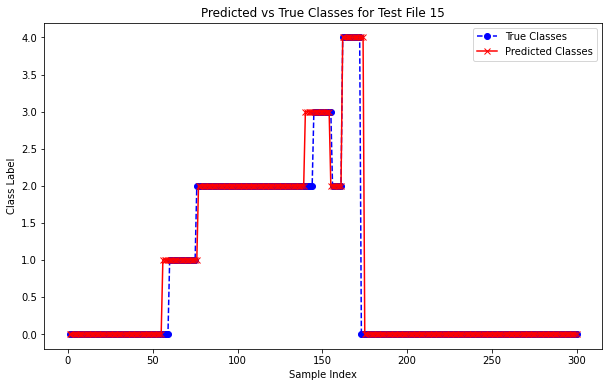

In [14]:
import numpy as np
import matplotlib.pyplot as plt


# Create a plot to visualize the predicted vs true classes
plt.figure(figsize=(10, 6))
plt.plot(range(1, 301), true_classes, label="True Classes", color='blue', linestyle='dashed', marker='o')
plt.plot(range(1, 301), predicted_classes, label="Predicted Classes", color='red', marker='x')

# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.title(f'Predicted vs True Classes for Test File {file_index + 1}')
plt.legend()

# Show the plot
plt.show()


In [15]:
# Check accuracy for this particular sequence at each sample
correct_predictions = predicted_classes == true_classes

# Loop through each sample to print individual accuracy
for i in range(len(correct_predictions)):
    result = "Correct" if correct_predictions[i] else "Incorrect"
    print(f"Sample {i + 1}: Predicted = {predicted_classes[i]}, True = {true_classes[i]} ({result})")



Sample 1: Predicted = 0, True = 0 (Correct)
Sample 2: Predicted = 0, True = 0 (Correct)
Sample 3: Predicted = 0, True = 0 (Correct)
Sample 4: Predicted = 0, True = 0 (Correct)
Sample 5: Predicted = 0, True = 0 (Correct)
Sample 6: Predicted = 0, True = 0 (Correct)
Sample 7: Predicted = 0, True = 0 (Correct)
Sample 8: Predicted = 0, True = 0 (Correct)
Sample 9: Predicted = 0, True = 0 (Correct)
Sample 10: Predicted = 0, True = 0 (Correct)
Sample 11: Predicted = 0, True = 0 (Correct)
Sample 12: Predicted = 0, True = 0 (Correct)
Sample 13: Predicted = 0, True = 0 (Correct)
Sample 14: Predicted = 0, True = 0 (Correct)
Sample 15: Predicted = 0, True = 0 (Correct)
Sample 16: Predicted = 0, True = 0 (Correct)
Sample 17: Predicted = 0, True = 0 (Correct)
Sample 18: Predicted = 0, True = 0 (Correct)
Sample 19: Predicted = 0, True = 0 (Correct)
Sample 20: Predicted = 0, True = 0 (Correct)
Sample 21: Predicted = 0, True = 0 (Correct)
Sample 22: Predicted = 0, True = 0 (Correct)
Sample 23: Predicte

In [16]:
# Calculate overall accuracy for the sequence
accuracy = np.mean(correct_predictions)
print(f"Overall Accuracy for file {file_index + 1}: {accuracy:.4f}")

Overall Accuracy for file 15: 0.9567


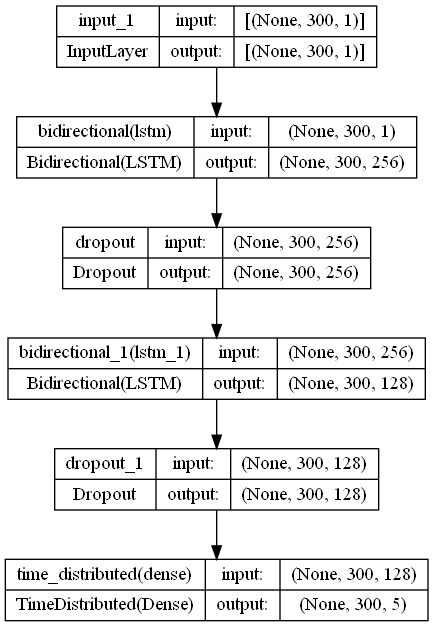

In [24]:
from tensorflow.keras.utils import plot_model

# Create the model as usual
model = Model(inputs=input_layer, outputs=output_layer)

# Plot the model architecture and save it to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
